# Исследование  маркетинговой стратегии компании

*Цель исследования:*
Провести анализ рекламного бюджета: выявить факторы, мешающие привлечению клиентов, найти точки роста.

*Исходные характеристики данных:*
Данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

 Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.
 
 *Описание данных:*
 
Структура visits_info_short.csv:

- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info_short.csv:

- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура costs_info_short.csv:

- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Функции-для-расчёта-и-анализа-LTV,-ROI,-удержания-и-конверсии." data-toc-modified-id="Функции-для-расчёта-и-анализа-LTV,-ROI,-удержания-и-конверсии.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Функции для расчёта и анализа LTV, ROI, удержания и конверсии.</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Маркетинг" data-toc-modified-id="Маркетинг-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Маркетинг</a></span></li><li><span><a href="#Оценка-окупаемости-рекламы" data-toc-modified-id="Оценка-окупаемости-рекламы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Оценка окупаемости рекламы</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#запуск на платформе Практикума
try:
    visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info_short.csv'),  # покупки
    pd.read_csv('/datasets/costs_info_short.csv'),  # траты на рекламу
)

#локальный запуск    
except:
    visits, orders, costs = (
    pd.read_csv('./visits_info_short.csv'),  # журнал сессий
    pd.read_csv('./orders_info_short.csv'),  # покупки
    pd.read_csv('./costs_info_short.csv'),  # траты на рекламу
)    

## Предобработка данных

**Проверка на дубликаты:**

In [3]:
visits.duplicated().sum() 

0

In [4]:
orders.duplicated().sum()

0

In [5]:
costs.duplicated().sum()

0

Дубликатов не обнаружено.

**Проверка на пропуски:**

In [6]:
pd.DataFrame(round(visits.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
User Id,0.000000
Region,0.000000
Device,0.000000
Channel,0.000000
Session Start,0.000000
Session End,0.000000


In [7]:
pd.DataFrame(round(orders.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
User Id,0.000000
Event Dt,0.000000
Revenue,0.000000


In [8]:
pd.DataFrame(round(costs.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
dt,0.000000
Channel,0.000000
costs,0.000000


Пропусков не обнаружено.

**Проверка типов данных:**

In [9]:
visits.dtypes

User Id           int64
Region           object
Device           object
Channel          object
Session Start    object
Session End      object
dtype: object

In [10]:
visits = visits.rename(columns = {'User Id' : 'user_id', 'Session Start' : 'session_start', 'Session End' : 'session_end'})
visits.columns= visits.columns.str.lower()

Перевод даты в формат datetime:

In [11]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [12]:
orders.dtypes

User Id       int64
Event Dt     object
Revenue     float64
dtype: object

In [13]:
orders = orders.rename(columns = {'User Id' : 'user_id', 'Event Dt' : 'event_dt'})
orders.columns = orders.columns.str.lower()

Перевод даты в формат datetime:

In [14]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [15]:
costs.dtypes

dt          object
Channel     object
costs      float64
dtype: object

In [16]:
costs.columns = costs.columns.str.lower()

Перевод даты в формат datetime:

In [17]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

**Выводы по разделу:**

- дубликаты и пропуски в исходных датасетах отсутствуют
- столбцы, содержащие дату, переведены в формат datetime

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Создадим функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [18]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [19]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [20]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [21]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [22]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [23]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [24]:
 # функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [25]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных

Задачи этапа:
- составить профили пользователей
- посчитать количество пользователей и долю платящих из каждой страны
- посчитать количество пользователей и долю платящих для каждого устройства
- изучить рекламные источники привлечения и определить каналы, из которых пришло больше всего платящих пользователей
- определить маркетинговые затраты на привлечение одного пользователя (CAC) из каждого источника

In [26]:
#профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [27]:
# минимальная и максимальная даты привлечения пользователей
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()

print('Минимальная дата:', min_date)
print('Максимальная дата:', max_date)

Минимальная дата: 2019-05-01
Максимальная дата: 2019-10-27


Убедимся, что временной интервал в представленном наборе данных с 1 мая 2019г. по 27 октября 2019г.

In [28]:
# анализ платящих пользователей в зависимости от страны
payer_users_by_counry = profiles.groupby('region')\
                .agg({'payer' : ['count', 'sum', 'mean']})

payer_users_by_counry.columns = ['total_users', 'payer_users', 'rate_of_payer_users']
payer_users_by_counry.sort_values('rate_of_payer_users', ascending = False)

,total_users,payer_users,rate_of_payer_users
region,,,
United States,100002,6902,0.069019
Germany,14981,616,0.041119
UK,17575,700,0.039829
France,17450,663,0.037994


В приложении есть пользователи из 4 стран: США, Великобритании, Франции, Германии.
Больше всего пользователей за исследуемый период было привлечено из США, к тому же доля платящих пользователей в этой стране тоже самая высокая - 6,9%. Менее всего пользователей из Германии, но доля платящих пользователей здесь выше, чем в Великобритании или Франции - 4,1%. В великобритании доля платящих пользователей составила почти 4%, во Франции - 3,8%.

In [29]:
# анализ платящих пользователей в зависимости от типа устройства
payer_users_by_device = profiles.groupby('device')\
                .agg({'payer' : ['count', 'sum', 'mean']})

payer_users_by_device.columns = ['total_users', 'payer_users', 'rate_of_payer_users']
payer_users_by_device.sort_values('rate_of_payer_users', ascending = False)

,total_users,payer_users,rate_of_payer_users
device,,,
Mac,30042,1912,0.063644
iPhone,54479,3382,0.062079
Android,35032,2050,0.058518
PC,30455,1537,0.050468


Клиенты пользуются следующими устройствами: iPhone, Android, PC, Mac. Больше всего пользователей на устройствах iPhone, далее с заметным отставанием идут Android, PC и Mac. Однако, доля платящих пользователей немного выше именно среди обладателей Mac (6,4%) и iPhone (6,2%). У пользователей Android этот показателей 5,8%, PC - 5%.

In [30]:
# анализ платящих пользователей в зависимости от канала привлечения
payer_users_by_channel = profiles.groupby('channel')\
                .agg({'payer' : ['count', 'sum', 'mean']})

payer_users_by_channel.columns = ['total_users', 'payer_users', 'rate_of_payer_users']
payer_users_by_channel.sort_values('rate_of_payer_users', ascending = False)

,total_users,payer_users,rate_of_payer_users
channel,,,
FaceBoom,29144,3557,0.122049
AdNonSense,3880,440,0.113402
lambdaMediaAds,2149,225,0.104700
TipTop,19561,1878,0.096007
RocketSuperAds,4448,352,0.079137
WahooNetBanner,8553,453,0.052964
YRabbit,4312,165,0.038265
MediaTornado,4364,156,0.035747
LeapBob,8553,262,0.030633


Самыми распространенными каналами привлечения можно назвать: органический, FaceBoom и TipTop. 
Больше всего пользователей было привлечено органически/без рекламы, но, как результат, эти пользователи оказались самыми неплатящими, доля платящих составляет всего 2%. Самыми результативными источниками в контексте привлечения платящих пользователей стали каналы FaceBoom (12,2%), AdNonSense (11,3%) и lambdaMediaAds (10,5%).

## Маркетинг

Задачи этапа:
- посчитать общую сумму расходов на маркетинг
- выяснить, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник
- построить визуализации динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику
- определить, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника

In [31]:
costs

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


In [32]:
#общая сумма расходов на маркетинг
costs['costs'].sum()

105497.30000000002

Общие траты на маркетинг за исследуемый период составили почти 105.5 тыс.долл.

In [33]:
#распределение трат по рекламным источникам
costs.groupby('channel')\
     .agg({'costs' : 'sum'})\
     .sort_values('costs', ascending = False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Самыми дорогими рекламными источниками привлечения пользователей приложения являются TipTop (54,7 тыс.долл.) и FaceBoom (32,4 тыс.долл.). Расходы на рекламу по прочим источникам не превышают 5,2 тыс.долл.

In [34]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month

In [35]:
costs_by_week = costs.groupby(['week', 'channel'])\
                     .agg({'costs': 'sum'})\
                     .reset_index()
costs_by_week.head()

,week,channel,costs
0,18,AdNonSense,211.05
1,18,FaceBoom,535.70
2,18,LeapBob,16.80
3,18,MediaTornado,38.64
4,18,OppleCreativeMedia,24.00


In [36]:
costs_by_month = costs.groupby(['month', 'channel'])\
                     .agg({'costs': 'sum'})\
                     .reset_index()
costs_by_month.head()

,month,channel,costs
0,5,AdNonSense,1169.70
1,5,FaceBoom,3524.40
2,5,LeapBob,140.28
3,5,MediaTornado,238.56
4,5,OppleCreativeMedia,169.75


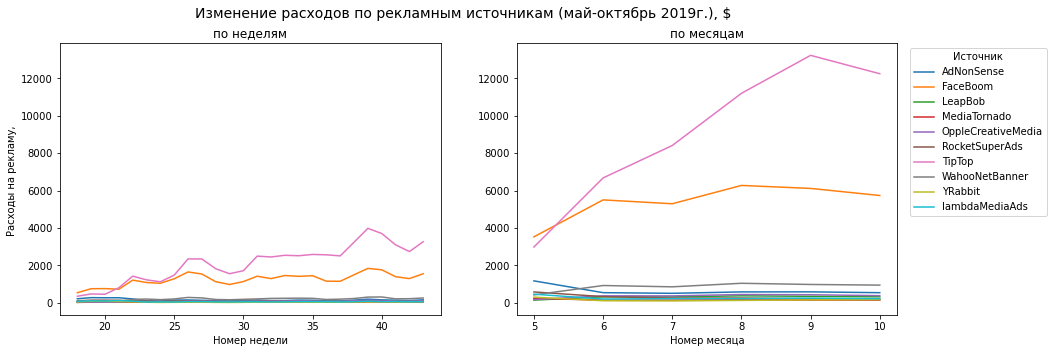

In [37]:
plt.figure(figsize=(15, 5)) # задаём размер сетки для графиков

#график по неделям
sns.lineplot(data=costs_by_week, x='week', y='costs', hue='channel', ax=plt.subplot(1, 2, 1))
plt.title('по неделям')
plt.xlabel('Номер недели')
plt.ylabel('Расходы на рекламу, ')
plt.legend().set_visible(False)

#график по месяцам
sns.lineplot(data=costs_by_month, x='month', y='costs', hue='channel', ax=plt.subplot(1, 2, 2, sharey = plt.subplot(1, 2, 1))
)  
plt.title('по месяцам')
plt.xlabel('Номер месяца')
plt.ylabel('')
plt.legend().set_visible(False)

plt.suptitle('Изменение расходов по рекламным источникам (май-октябрь 2019г.), $ ', fontsize=14)
plt.legend(title= 'Источник', title_fontsize = 10,  prop = {'size' : 10}, bbox_to_anchor= (1.02, 1));

Динамика изменения расходов подтверждает тот факт, что по сумме трат (за неделю/месяц) на протяжении всего периода явно видны 2 лидера: TipTop и FaceBoom. Причем вложения средств в TipTop с середины мая постепенно увеличивались, что нельзя сказать о прочих рекламных источниках. Суммы затрат у них оставались примерно постоянными на протяжении всего промежутка времени.

In [38]:
#средний CAC по каналам привлечения

cac = profiles.groupby('channel')\
              .agg({'acquisition_cost': 'mean'})\
              .rename(columns={'acquisition_cost': 'cac'})\
              .sort_values(by = 'cac', ascending = False)
                      
cac

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Средние траты на привлечение пользователя с помощью канала TipTop составили 2,8 долл., что более чем в 2,5 раза выше, чем у прочих каналов.

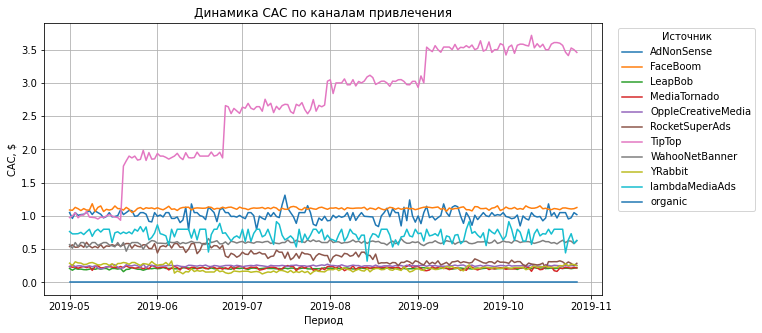

In [39]:
# график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Период')
plt.title('Динамика САС по каналам привлечения')
plt.legend(title= 'Источник', title_fontsize = 10,  prop = {'size' : 10}, bbox_to_anchor= (1.02, 1));
plt.show()

Причем если посмотреть на динамику изменения CAC, то можно заметить, что средние траты на привлечение пользователя из канала TipTop увеличились в середине мая 2019г., и далее только возрастали скачкообразно в несколько ступеней.

Посмотрим еще на средний показатель рекламных расходов на 1-го пользователя, чтобы сравнить с полученными значениями CAC по отдельным рекламным каналам. Предварительно уберем из расчета органических пользователей, чтобы не исказить показатели:

In [40]:
mean_cac = profiles.query('channel != "organic"')['acquisition_cost'].mean()
mean_cac

1.127481323942928

Средний уровень рекламных расходов на 1-го пользователя с учетом всех рекламных источников - 1,13 долл. Если сравнить этот показатель с полученной таблицей трат по рекламным каналам и динамикой CAC, то снова можно отметить лишь одно выбивающееся значение - канал TipTop (2,8 долл.). Получается, что привлечение пользователя из этого канала обходилось компании в среднем в 2,5 раза дороже, чем из других источников.

**Выводы по разделу:**

- Общие траты на маркетинг за исследуемый период составили почти 105.5 тыс.долл.
- Самыми дорогими рекламными источниками привлечения пользователей приложения являются TipTop и FaceBoom.
- Вложения средств в источник TipTop постепенно увеличивались за указанный период времени, в то время как траты на другие источники оставались примерно постоянными на протяжении всего времени.
- Траты на привлечение пользователя с помощью канала TipTop составили 2,8 долл., что в среднем в 2,5 раза выше среднего показателя CAC по всем источникам - 1,13 долл. 
- Средние траты на привлечение пользователя из канала TipTop увеличились в середине мая 2019г., и далее только возрастали, что говорит об отсутствии эффекта увеличения количества пользователей в условиях постоянного повышения затрат на рекламу.

## Оценка окупаемости рекламы

Задачи этапа:

- проанализировать окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI
- изучить конверсию и удержание пользователей и динамику их изменения, построить графики
- проанализировать окупаемость рекламы с разбивкой по устройствам (графики LTV и ROI, а также графики динамики LTV, CAC и ROI)
- проанализировать окупаемость рекламы с разбивкой по странам (графики LTV и ROI, а также графики динамики LTV, CAC и ROI)
- проанализировать окупаемость рекламы с разбивкой по рекламным каналам (графики LTV и ROI, а также графики динамики LTV, CAC и ROI)

In [41]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Исключим из анализа органических пользователей, чтобы понять эффективность проводимых рекламных компаний:

In [42]:
profiles = profiles.query('channel != "organic"')
profiles.shape[0]

93569

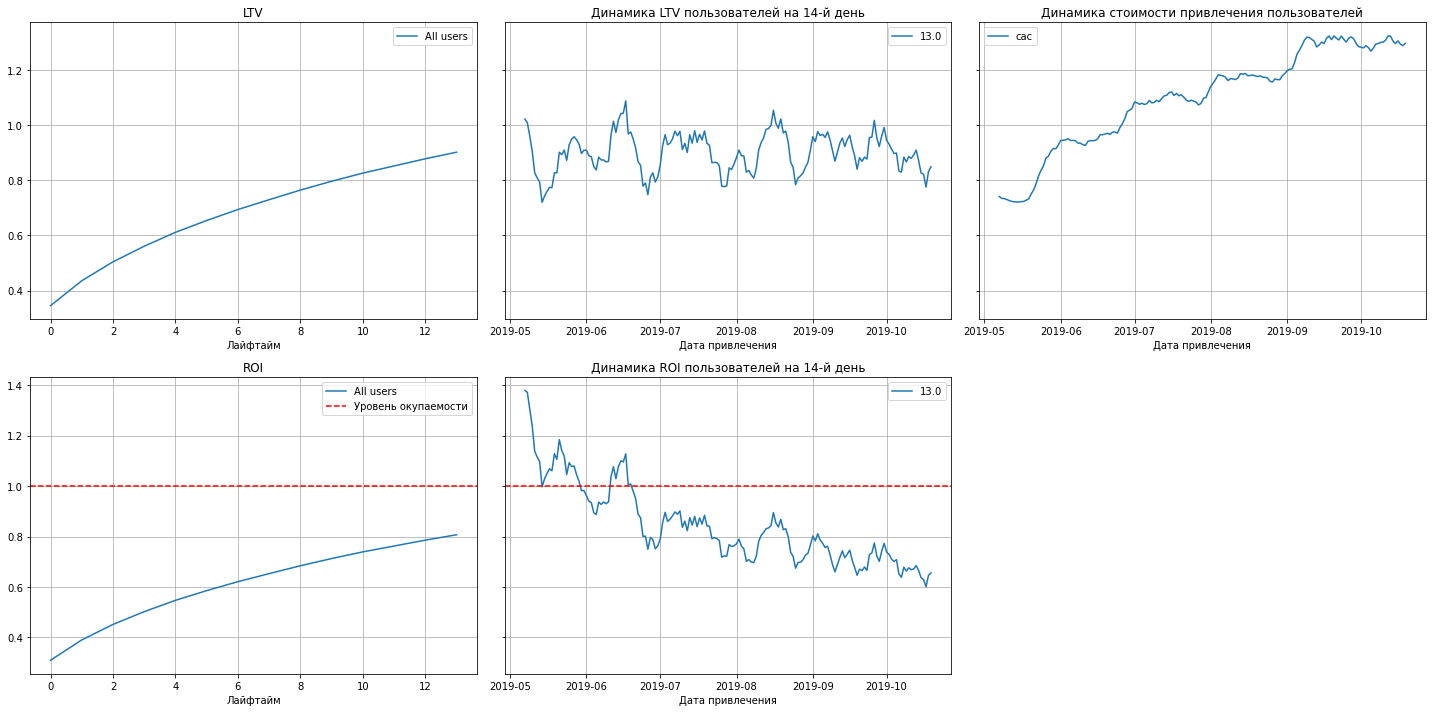

In [43]:
# расчет LTV
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно отметить, что:
- LTV пользователей на 14ый день имеет небольшую флуктуацию, но достаточно стабилен в своем диапазоне;
- CAC не стабилен, рекламный бюджет на протяжении исследуемого периода увеличивается быстрее, чем прирост новых пользователей;
- на 14 день лайфтайма пользователей затраты на привлечение не окупаются (ROI < 1);
- за исследуемый период показатель окупаемости рекламы на 14ый день в когортах сильно ухудшился с почти 140% в начале мая до 60% к октябрю, нужно искать причины такого падения.

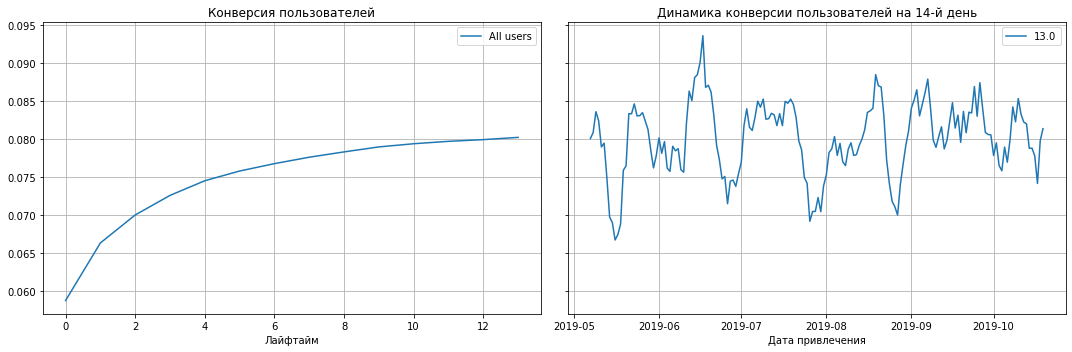

In [44]:
# расчет конверсии
result_raw, result_grouped, result_in_time = get_conversion(
                                                                profiles,
                                                                orders,
                                                                observation_date,
                                                                horizon_days,
                                                           )
# графики конверсии
plot_conversion(result_grouped, result_in_time, horizon_days, window=7)

По графику конверсии пользователей можно увидеть, что на 14ый день конверсия составила в среднем около 8%. График динамики конверсии показывает, что несмотря на флуктуацию конверсия за исследуемый период находилась в диапазоне 7-9%.

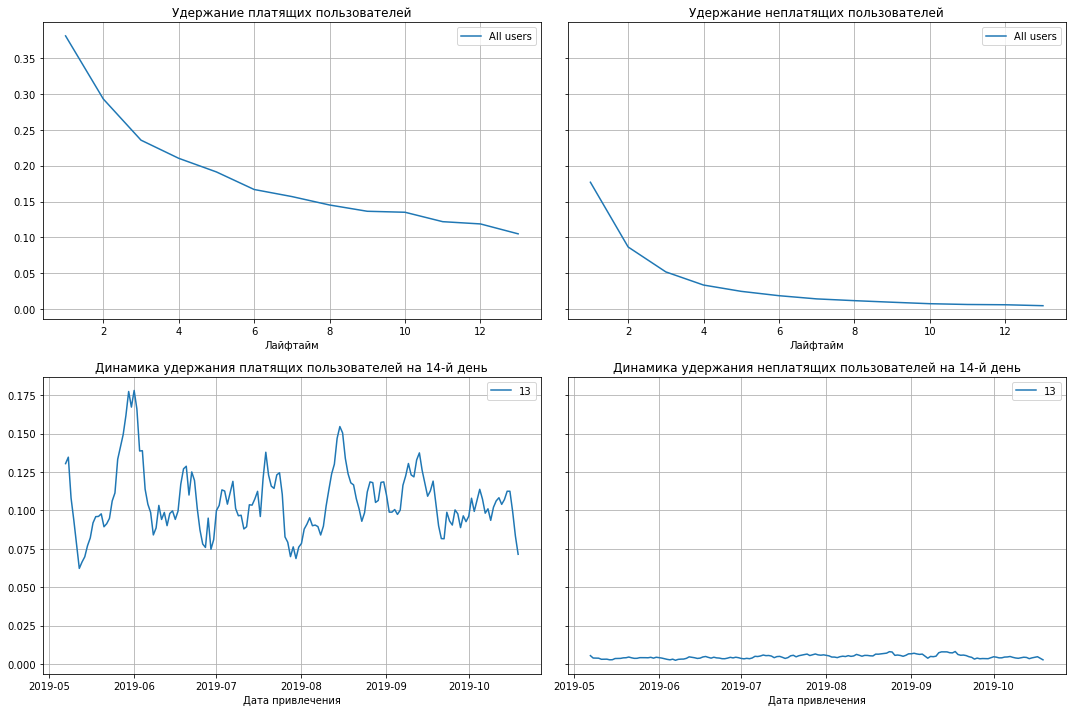

In [45]:
# расчет удержания
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)
# графики удержания
plot_retention(retention_grouped, retention_history, horizon_days) 

Коэффициент удержания платящих пользователей за 14 дней лайфтайма постепенно снижается с 38% до 10%. Динамика удержания пользователей по когортам дат привлечения находится, в основном, в диапазоне 7-15%. По этой картине найти проблему трудно, поэтому изучим коэффициенты в резрезе различных измерений.

Посмотрим на показатели конверсии в разрезе типов устройств, стран и каналов привлечения:

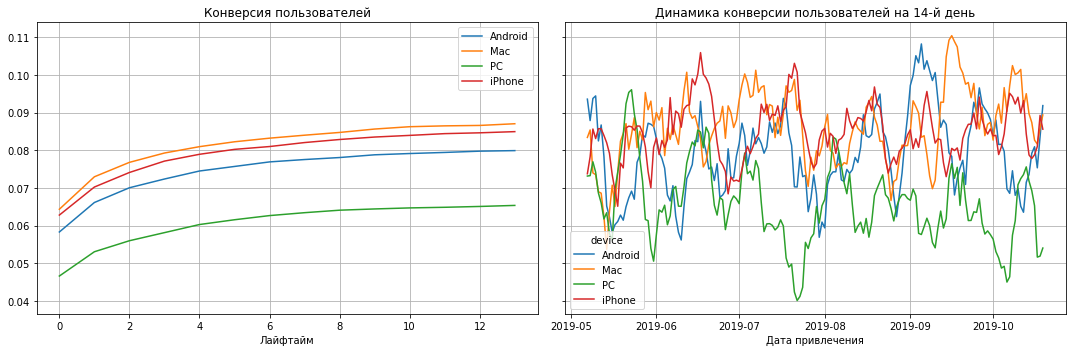

In [46]:
# расчет конверсии зависимости от типа устройства
result_raw, result_grouped, result_in_time = get_conversion(
                                                                profiles,
                                                                orders,
                                                                observation_date,
                                                                horizon_days,
                                                                dimensions=['device']
                                                           )
# графики конверсии
plot_conversion(result_grouped, result_in_time, horizon_days, window=7)

Хуже всего к 14-му дню лайфтайма конвертируются пользователи PC. Лучше всего - пользователи Mac и iPhone, чуть хуже Android.  Если посмотреть на динамику то были когорты, когда лидировал каждый тип из имеющихся устройств. Например, в мае были когорты, когда пользователи PC конвертировались лучше всего, но это скорее исключение.

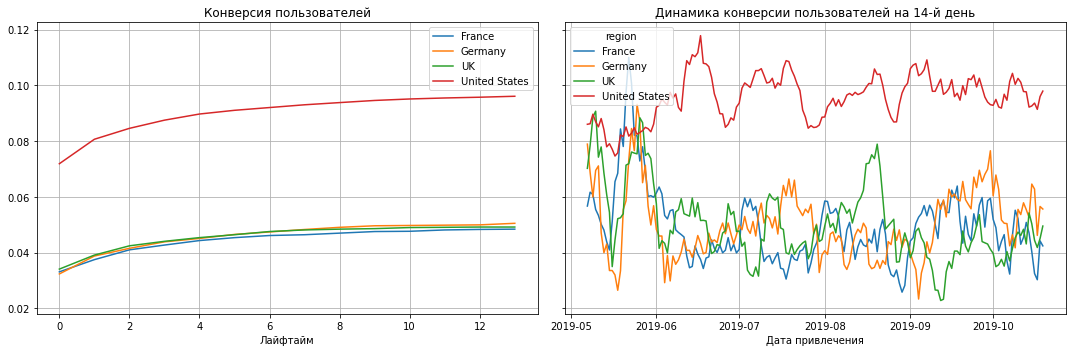

In [47]:
# расчет конверсии зависимости от страны
result_raw, result_grouped, result_in_time = get_conversion(
                                                                profiles,
                                                                orders,
                                                                observation_date,
                                                                horizon_days,
                                                                dimensions=['region']
                                                           )
# графики конверсии
plot_conversion(result_grouped, result_in_time, horizon_days, window=7)

Стабильно лучше других стран конвертировались пользователи США. Если посмотреть на динамику, то можно заметить, что был момент в середине мая, когда в лидеры вырывались пользователи Франции, Германии, Великобритании, но к июню в постоянные лидеры вышли пользователи США.

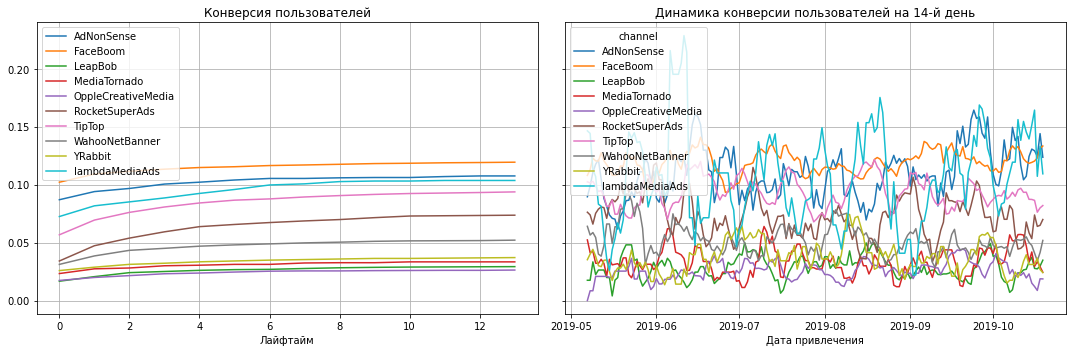

In [48]:
# расчет конверсии в зависимости от канала привлечения
result_raw, result_grouped, result_in_time = get_conversion(
                                                                profiles,
                                                                orders,
                                                                observation_date,
                                                                horizon_days,
                                                                dimensions=['channel']
                                                           )
# графики конверсии
plot_conversion(result_grouped, result_in_time, horizon_days, window=7)

Показатели конверсии немного выше у пользователей из каналов FaceBoom, AdNonSense, LambdaMediaAds. По динамике все каналы идут относительно на одном уровне, но в мае и начале июня были особенно успешные когорты для канала LambdaMediaAds.


Посмотрим на показатели удержания в разрезе типов устройств, стран и каналов привлечения:

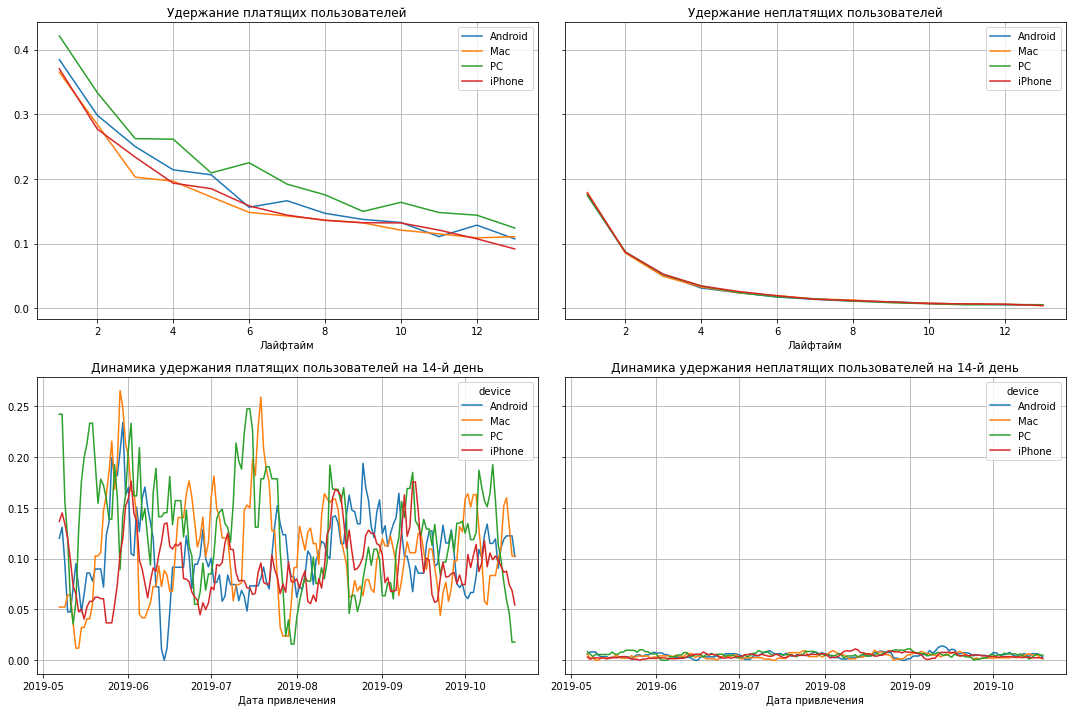

In [49]:
# расчет удержания в зависимости от типа устройства
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)
# графики удержания
plot_retention(retention_grouped, retention_history, horizon_days) 

Трудно сказать, что на удержание платящих пользователей сильно влияет тип устройства. В среднем, чуть лучше показатели удержания у пользователей PC.

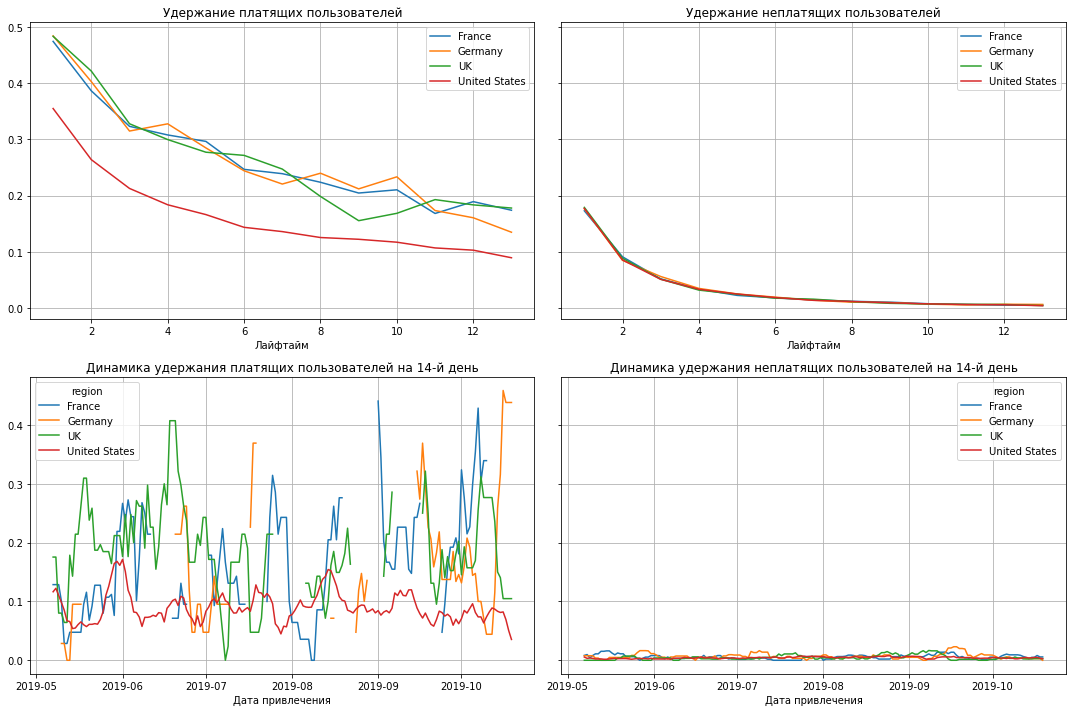

In [50]:
# расчет удержания в зависимости от страны
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)
# графики удержания
plot_retention(retention_grouped, retention_history, horizon_days) 

Как ни странно, но пользователи США, где процент платящих пользователей выше, чем удругих стран, удерживаются хуже. Конечно, стоит отметить тот факт, что выборки неоднородны. Пользователей США в 2 раза больше, чем пользователей представленных стран Европы в сумме. Возможно поэтому показатели стран Европы имеют такую сильную волитильность, если смотреть на график динамики удержания.

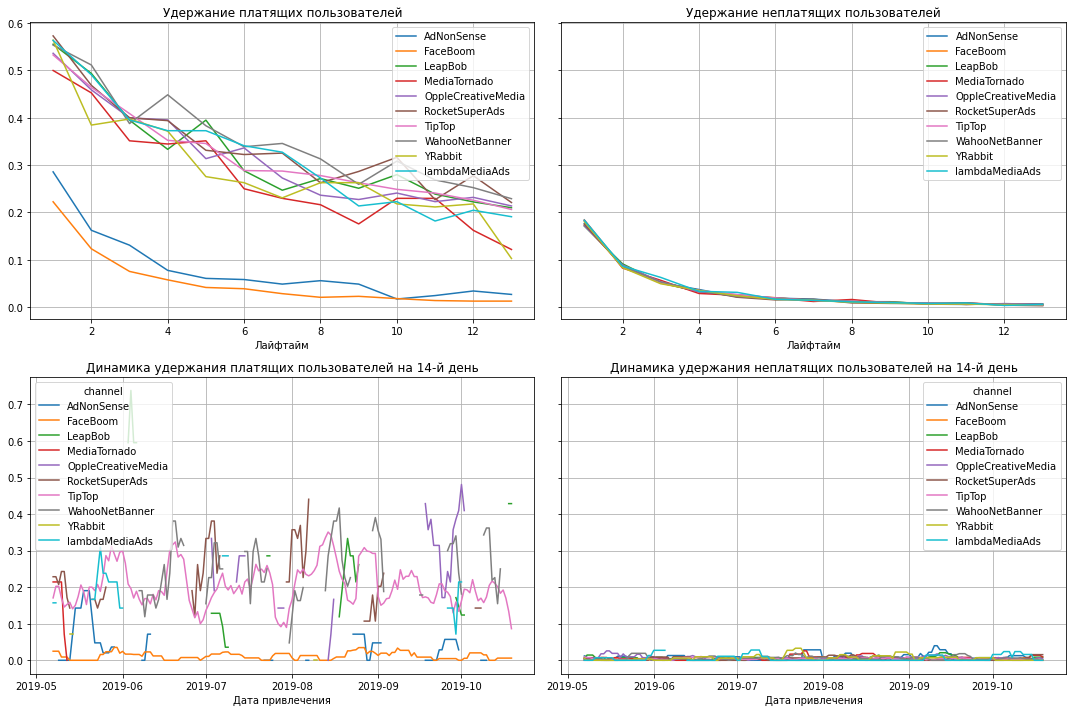

In [51]:
# расчет удержания в зависимости от канала привлечения
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)
# графики удержания
plot_retention(retention_grouped, retention_history, horizon_days) 

Хуже всего удерживаются пользователи, привлеченные из каналов FaceBoom и AdNonSense. Хотя, как мы помним, эти каналы показали самые высокие результаты в контексте привлечения платящих пользователей. Видимо, после совершения покупки, эти пользователи быстро "отваливаются".

Посмотрим на окупаемость рекламы  в разрезе типов устройств, стран и каналов привлечения:

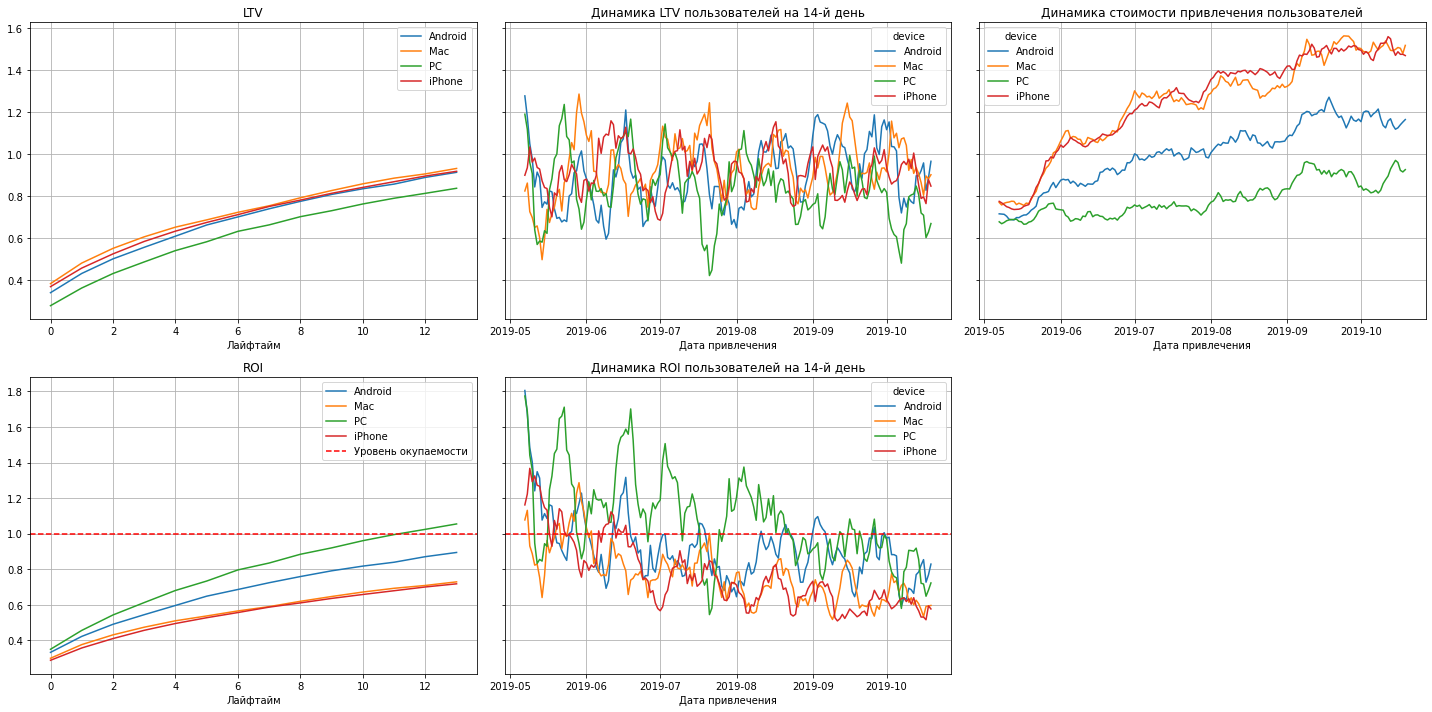

In [52]:
# расчет LTV в зависимости от типа устройства
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Средняя доходность на одного пользователя примерно одинакова у пользователей Android, iPhone и Mac, немного ниже у пользователей PC, но зато у них самая низкая стоимость привлечения. За счет этого пользователь PC окупается на 11 день лайфтайма. Пользователи Anroid, iPhone и Mac не окупаются вовсе за 14 дней. Это связано с высокой стоимостью привлечения таких пользователей. Если посмотреть на динамику окупаемости рекламы, то можно заметить, что она падала с течением времени у пользователей всех устройств так, что в октябре перестали окупаться даже пользователи PC.

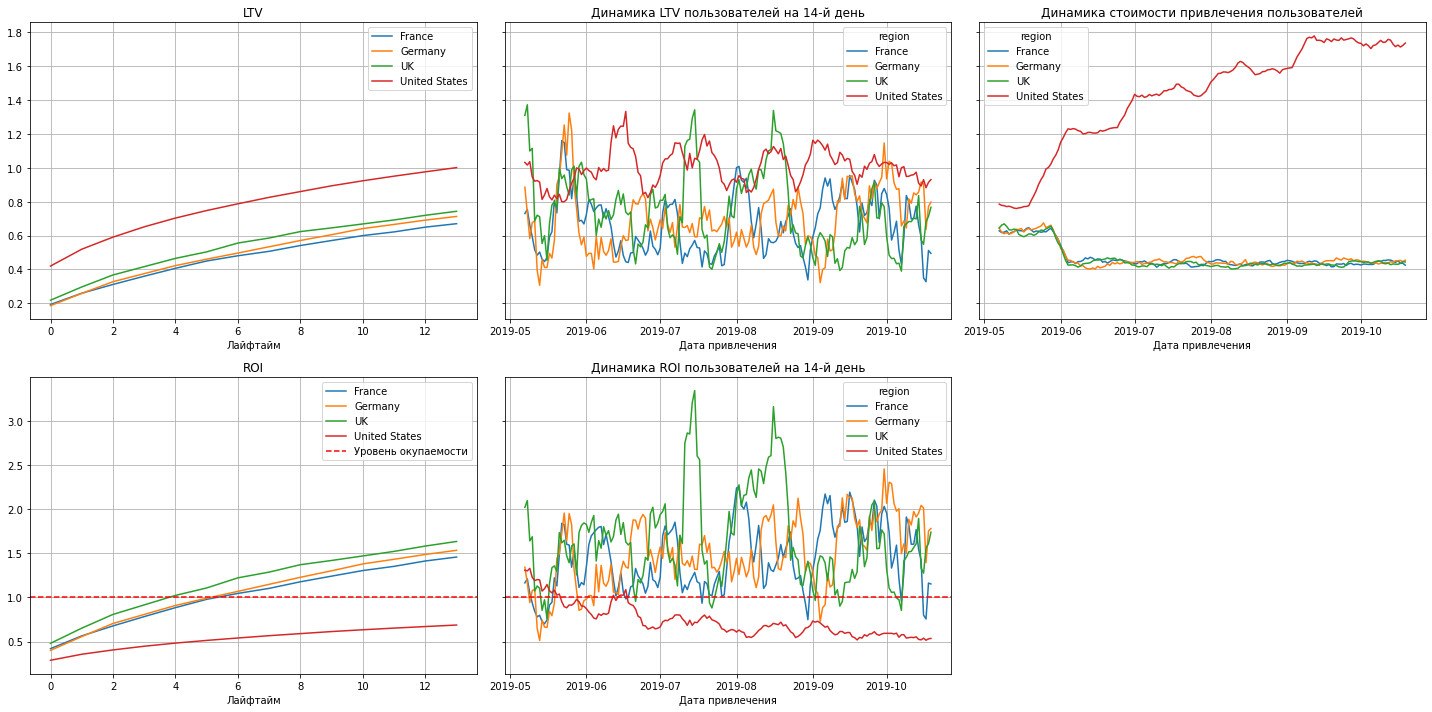

In [53]:
# расчет LTV в зависимости от страны пользователя
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Посмотрим на показатели по странам. В глаза бросается кривая доходности пользователей из США: они приносят приложению больше всего дохода в расчете на одного пользователя за 14 дней лайтайма. Однако,  если обратить внимание на стоимость привлечения пользователя из США, то можно отметить, что начиная с мая она выросла более, чем в 2 раза (с 0,8 долл. до 1,7 долл.!). При том, что стоимость привлечения пользователей из других стран в этот же момент снизилась и за указанный период практически не менялась (0,4 - 0,5 долл.). Поскольку затраты на рекламу пользователей из США превышали получаемые от них доходы, за 14 дней такие пользователи не окупались (ROI < 1), в отличие от пользователей из других стран, где окупаемость к 6 дню уже превышала единицу, а в среднем такие пользователи к 14-ому дню окупались почти в 1,5 раза.
На графиках динамики видно, что убытки от привлечения пользователей из США начались с июня 2019, когда кратно выросли расходы на рекламу для их привлечения.

In [54]:
# LTV по странам на 14-ый день
LTV_US_vs_Europe =  ltv_grouped[13]
LTV_US_vs_Europe

region
France           0.670278
Germany          0.713019
UK               0.743481
United States    1.001316
Name: 13.0, dtype: float64

In [55]:
# средний LTV на 14-ый день стран Европы
round((LTV_US_vs_Europe['France'] + LTV_US_vs_Europe['Germany'] + LTV_US_vs_Europe['UK']) / 3, 1)

0.7

In [56]:
# средние значения СAC по странам
cac_US_vs_Europe = profiles.groupby('region')\
              .agg({'acquisition_cost': 'mean'})\
              .rename(columns={'acquisition_cost': 'cac'})\
              .sort_values(by = 'cac', ascending = False)
                      
cac_US_vs_Europe

,cac
region,
United States,1.470646
Germany,0.464339
France,0.459032
UK,0.454411


In [57]:
# средние значение СAC по странам Европы
round((cac_US_vs_Europe['cac'][1] +cac_US_vs_Europe['cac'][2] + cac_US_vs_Europe['cac'][3]) / 3, 1)

0.5

In [58]:
# ROI по странам на 14-ый день
ROI_US_vs_Europe = roi_grouped[13]
ROI_US_vs_Europe

region
France           1.457644
Germany          1.533709
UK               1.634306
United States    0.687776
Name: 13.0, dtype: float64

In [59]:
# средний ROI на 14-ый день стран Европы
round((ROI_US_vs_Europe['France'] + ROI_US_vs_Europe['Germany'] + ROI_US_vs_Europe['UK']) / 3, 1)

1.5

Доходность от пользователя США на 14-ый день лайфтайма была в среднем на 30% выше пользователя из Европы (1 долл. против 0,7 долл.). Но траты на привлечение пользователя из США были, в среднем, в 3 раза больше (!), чем пользователя из Европы (1,5 долл. против 0,5 долл.). Поэтому пользователи из Европы смогли окупить рекламный бюджет, в среднем, в 1,5 раза, а пользователи США оказались убыточны (154% против 69%).

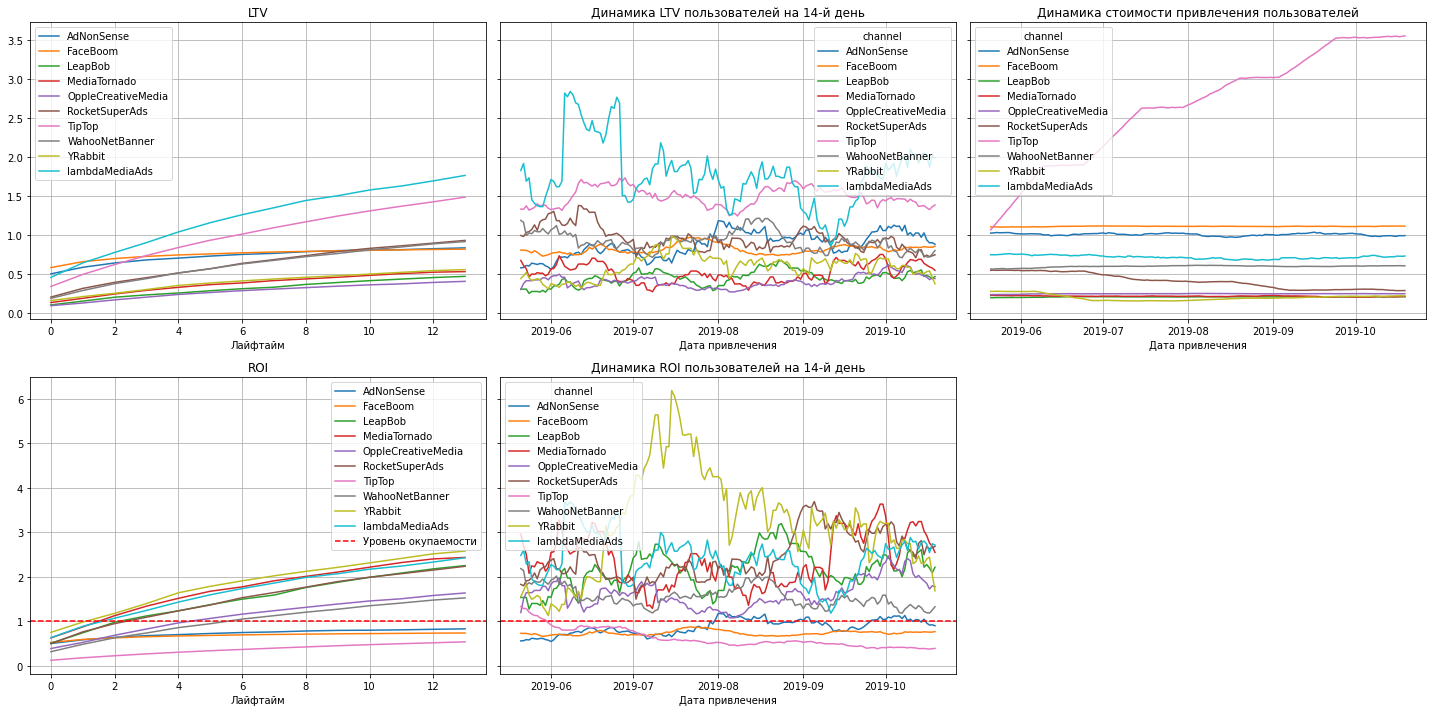

In [60]:
# расчет LTV в зависимости от канала привлечения
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=21) 

Средняя доходность на одного пользователя выше всего у каналов LambdaMediaAds и TipTop. Причем если смотреть на график динамики LTV, на протяжении всего периода также будут лидировать эти 2 канала, но лучшие показатели демонстрирует именно LambdaMediaAds. Но вот стоимость привлечения в эих каналах отличается радикально. Если у LambdaMediaAds CAC стабилен и составляет около 0,7 долл., то у TipTop этот показатель поднимался ступенчато несколько раз за период и достиг отметки в 3.5 долл. Видимо, именно этот канал был направлен на привлечение пользователей из США. Также к убыточным каналам можно отнести FaceBoom и AdNonSense, траты на привлечения пользователей из этих каналов не окупались за 14 дней лайфтайма.
Перспективными каналами по показателям окупаемости можно назвать: YRabbit (особенно в июле), MediaTornado, LambdaMediaAds, LeapBob, RocketSuperAds.

**Выводы по разделу:**

- Хуже всего к 14-му дню лайфтайма конвертировались пользователи PC. Лучше всего - пользователи Mac и iPhone, чуть хуже Android.
- Стабильно лучше других стран конвертировались пользователи США, но удержание к 14-му дню лайфтайма у них хуже пользователей из других стран. Видимо, эти пользователи быстро "отваливаются" после совершения покупки.
- Показатели конверсии лучше у пользователей, привлеченных из каналов FaceBoom, AdNonSense, LambdaMediaAds
- Хуже всего удерживаются пользователи, привлеченные из каналов FaceBoom и AdNonSense, хотя у них высокие показатели в контексте привлечения платящих пользователей и конверсии.
- Реклама, направленная на привлечение пользователей за исследуемый период времени, не окупалась через 2 недели после привлечения (ROI = 0.8).
- Ниже всего показатель окупаемости рекламы (ROI) у пользователей на устройствах iPhone, Mac и Android. При почти одинаковом уровне доходности в сравнении с другими устройствами, стоимость привлечения пользователей на iPhone и Mac гораздо выше.
- Выявлена явная проблема в привлечении пользователей из США. При больших бюджетах на рекламу для пользователей этой страны, доходность от них показывает хоть и высокие показатели (в сравнении с другими странами), но недостаточные для того, чтобы покрыть траты на рекламу. Именно эти пользователи показали убыточные результаты в расчете за 14 дней лайфтайма (ROI < 1). 
- Выявлены нерентабельные каналы привлечения пользователей: TipTop, FaceBoom и AdNonSense. Причем суммарные траты на рекламу были выше всего именно в каналах TipTop и FaceBoom.
- Исходя из данных, на канал привлечения пользователей из США - TipTop возлагались большие надежды, это видно по ежемесячному увеличению трат на рекламу. Но эти пользователи не показали какой-либо "сверхдоходности", и, как результат, стали убыточны для компании. Отделу маркетинга стоит обратить внимание на различия в показателях LTV и CAC именно этих пользователей и принять соответствующие решения по изменению рекламного бюджета.

## Выводы

*Цель исследования:*
Провести анализ рекламного бюджета: выявить факторы, мешающие привлечению клиаентов, найти точки роста.

*Исходные характеристики данных:*
Данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

*Предобработка данных:*
- дубликатов и пропусков в данных не обнаружено;
- даты переведены в формат datetime.

*Исследовательский анализ данных:*
- В приложении есть пользователи из 4 стран: США, Великобритании, Франции, Германии. Больше всего пользователей за исследуемый период было привлечено из США, к тому же доля платящих пользователей в этой стране тоже самая высокая - 6,9%. Менее всего пользователей из Германии, но доля платящих пользователей здесь выше, чем в Великобритании или Франции - 4,1%. В Великобритании доля платящих пользователей составила почти 4%, во Франции - 3,8%.
- Клиенты пользуются следующими устройствами: iPhone, Android, PC, Mac. Больше всего пользователей на устройствах iPhone, далее с заметным отставанием идут Android, PC и Mac. Однако, доля платящих пользователей немного выше именно среди обладателей Mac (6,4%) и iPhone (6,2%). У пользователей Android этот показателей 5,8%, PC - 5%.
- Самыми распространенными каналами привлечения можно назвать: органический, FaceBoom и TipTop. Больше всего пользователей было привлечено органически/без рекламы, но, как результат, эти пользователи оказались самыми неплатящими, доля платящих составляет всего 2%. Самыми результативными источниками в контексте привлечения платящих пользователей стали каналы FaceBoom (12,2%), AdNonSense (11,3%) и lambdaMediaAds (10,5%).

*Маркетинговый анализ:*
- Общие траты на маркетинг за исследуемый период составили почти 105.5 тыс.долл.
- Самыми дорогими рекламными источниками привлечения пользователей приложения являются TipTop и FaceBoom.
- Вложения средств в источник TipTop постепенно увеличивались за указанный период времени, в то время как траты на другие источники оставались постоянными на протяжении всего времени.
- Средние траты на привлечение пользователя с помощью канала TipTop составили 2,8 долл., что более чем в 2,5 раза выше, чем у канала FaceBoom (1,1 долл.). Стоимость привлечения пользователей из прочих каналов не превышает показатель в 1 долл.
- Средние траты на привлечение пользователя из канала TipTop увеличились в середине мая 2019г., и далее только возрастали, что говорит об отсутствии эффекта увеличения количества пользователей в условиях постоянного повышения затрат на рекламу.

*Анализ окупаемости рекламы:*
- Реклама, направленная на привлечение пользователей за исследуемый период времени, не окупалась через 2 недели после привлечения пользователей (ROI = 0.8).
- Ниже всего показатель окупаемости рекламы (ROI) у пользователей на устройствах iPhone, Mac и Android. При почти одинаковом уровне доходности в сравнении с другими устройствами, стоимость привлечения пользователей на iPhone и Mac гораздо выше.
- Выявлена явная проблема в привлечении пользователей из США. При больших бюджетах на рекламу для пользователей этой страны, доходность от них показывает хоть и высокие показатели (в сравнении с другими странами), но недостаточные для того, чтобы покрыть траты на рекламу. Именно эти пользователи показали убыточные результаты в расчете за 2 недели (ROI < 1).
- Выявлены нерентабельные каналы привлечения пользователей: TipTop, FaceBoom и AdNonSense. Причем суммарные траты на рекламу были выше всего именно в каналах TipTop и FaceBoom.
- Исходя из данных, на канал привлечения пользователей из США - TipTop возлагались большие надежды, это видно по ежемесячному увеличению трат на рекламу. Но эти пользователи не показали какой-либо "сверхдоходности", и, как результат, стали убыточны для компании. 


**Причины неэффективности привлечения пользователей:**

- Основной упор отдела маркетинга был направлен на привлечение пользователей из США с помощью канала TipTop. Вложения в это направление начались с середины мая 2019г. и  ежемесячно увеличивались. Доходность (LTV) от пользователей США была хоть и немного выше доходности пользователей из других стран, но все же несоизмерима с огромными тратами на рекламу. В отличие от пользователей США клиенты из других стран показали окупаемость на уровне 150% даже при очень скромных показателях рекламного бюджета.
- Большой бюджет был выделен и источнику FaceBoom, однако показатели доходности пользователей не позволили окупить затраты на  рекламу.
- Высокая стоимость привлечения пользователей на Anroid и iPhone не оправдала себя. Платежеспособность этих пользователей показала себя ничуть не выше гораздо более "экономных" для привлечения пользователей Anroid. А единственные окупившиеся пользователи - это PC, стоимость привлечения которых оказалась достаточно низкой.

**Рекомендации для отдела маркетинга:**

Отделу маркетинга стоит обратить внимание на:
- неэффективные источники привлечения пользователей и сократить их рекламный бюджет: TipTop, FaceBoom и AdNonSense;
- перспективные каналы привлечения пользователей, такие как: YRabbit, MediaTornado, LambdaMediaAds, LeapBob, RocketSuperAds;
- пользователей, привлеченных из Великобритании, Франции, Германии: они показали хорошие результаты по окупаемости, несмотря на то, что доля платящих пользователей в этих странах ниже, чем в США;
- пользователей на PC: при невысокой стоимости привлечения их доходность превысила затраты на рекламу (за 14 дней).

Рекомендуется:
- искать новые, более эффективные каналы привлечения пользователей из США;
- увеличить рекламный бюджет на другие страны (Великобритания, Франция, Германия);
- снизить затраты привлечения пользователей на iPhone и Mac, так как они не демонстрируют более высокую платежеспособность, сделать упор на пользователей Android и PC.